In [336]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import backtester_base as q_base
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
db = dm.read_db(base='prices_global.pkl', add=['prices_global_gwx.pkl'])
db_kr = dm.read_db(base='prices_kr.pkl', add=['prices_global.pkl'])

In [337]:
mix = q_base.BacktestComparator(setting.base_params(db), multiasset=multiasset, geam=geam, kfam=kfam, gsam=gsam, gfam=gfam)
mix.mix()

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


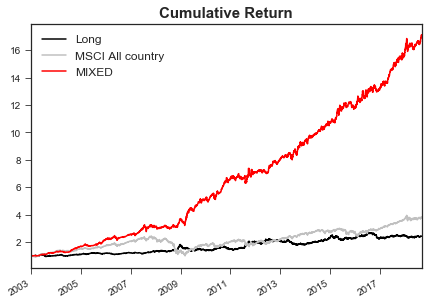

In [344]:
strats = ['BND_US_Long', 'ACWI', 'mixed']
names = ['Long', 'MSCI All country', 'MIXED']
color = ['k', 'silver', 'r']

mix.plot_cum(strats, names=names, color=color, logy=False)

In [339]:
mix.stats.tail(6)

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
multiasset,13.43,3946,17.89,13.86,1.29,-16.29,16.83,12.65,1.16,0.18,5.17,64.17,1.57,86.72
geam,8.66,3946,14.66,15.77,0.93,-23.31,14.34,15.74,0.92,0.23,12.85,61.50,1.31,90.12
kfam,34.22,3946,25.09,13.22,1.90,-18.16,24.45,12.20,2.17,0.09,7.74,71.66,1.53,94.00
gsam,8.00,3946,14.09,15.14,0.93,-20.52,14.02,13.65,0.99,0.36,9.28,62.03,1.32,97.81
gfam,3.15,3946,7.55,6.16,1.23,-12.06,5.97,5.36,1.22,0.02,2.89,66.84,1.29,97.19
mixed,17.13,3946,19.72,10.22,1.93,-15.35,17.51,9.38,2.08,0.19,1.51,71.66,1.59,96.67


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [335]:
mix.stats.tail(6)

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
multiasset,13.43,3946,17.89,13.86,1.29,-16.29,16.83,12.65,1.16,0.18,5.17,64.17,1.57,86.72
geam,8.66,3946,14.66,15.77,0.93,-23.31,14.34,15.74,0.92,0.23,12.85,61.50,1.31,90.12
kfam,34.22,3946,25.09,13.22,1.90,-18.16,24.45,12.20,2.17,0.09,7.74,71.66,1.53,94.00
gsam,8.00,3946,14.09,15.14,0.93,-20.52,14.02,13.65,0.99,0.36,9.28,62.03,1.32,97.81
gfam,3.15,3946,7.55,6.16,1.23,-12.06,5.97,5.36,1.22,0.02,2.89,66.84,1.29,97.19
mixed,10.65,3946,16.18,10.08,1.60,-15.00,15.47,9.33,1.75,0.14,3.38,67.91,1.56,96.31


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [340]:
rt = mix.cum.mixed.resample('M').ffill().pct_change()#.plot.bar()
rt[rt<-0.05]

2009-01-31   -0.069852
2010-05-31   -0.052269
Name: mixed, dtype: float64

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


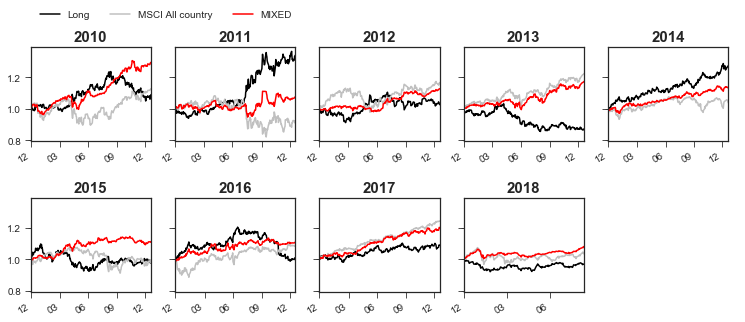

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [342]:
mix.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2010))

# Multiasset model

In [251]:
multiasset = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    n_picks=5, 
    assets=setting.assets_multiasset, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=24, 
    follow_trend=None, #(20,60), 
    follow_trend_market=None, #(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Short', 
    start='2002-12-31', 
    losscut=0.05, 
)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

24.82536220550537


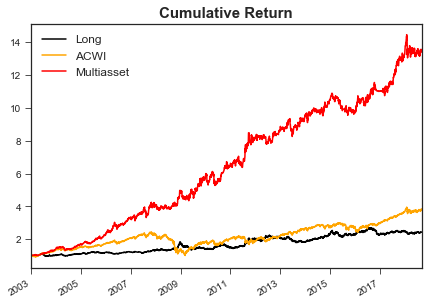

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [252]:
strats = ['BND_US_Long', 'ACWI', 'DualMomentum']
names = ['Long', 'ACWI', 'Multiasset']
color = ['k', 'orange', 'r']

multiasset.plot_cum(strats, names=names, color=color, logy=False)

In [236]:
rt = multiasset.cum.DualMomentum.resample('M').ffill().pct_change()
rt[rt<-0.05]

2004-04-30   -0.066624
2005-10-31   -0.054951
2007-08-31   -0.060135
2009-01-31   -0.113105
2009-04-30   -0.055583
2010-01-31   -0.061011
2010-05-31   -0.076306
2011-05-31   -0.051458
2013-05-31   -0.058287
2018-02-28   -0.060090
Name: DualMomentum, dtype: float64

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [119]:
hold_ = multiasset.hold.loc['2003-07', 'BND_US_Long']
#hold_[hold_==0] = np.nan
#hold_.dropna(axis=1)
hold_#['BND_US_TIP']

2003-07-01    1.549660e+06
2003-07-02    1.549660e+06
2003-07-03    1.549660e+06
2003-07-07    1.549660e+06
2003-07-08    1.549660e+06
2003-07-09    1.549660e+06
2003-07-10    1.549660e+06
2003-07-11    1.549660e+06
2003-07-14    1.549660e+06
2003-07-15    1.549660e+06
2003-07-16    1.549660e+06
2003-07-17    1.549660e+06
2003-07-18    1.549660e+06
2003-07-21    1.549660e+06
2003-07-22    7.748299e+05
2003-07-23    7.748299e+05
2003-07-24    7.748299e+05
2003-07-25    7.748299e+05
2003-07-28    7.748299e+05
2003-07-29    7.748299e+05
2003-07-30    7.748299e+05
2003-07-31    7.748299e+05
Name: BND_US_Long, dtype: float64

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [84]:
multiasset.p_close.loc['2003-07', 'BND_US_Long']

2003-07-01    52.8623
2003-07-02    52.9949
2003-07-03    52.2339
2003-07-07    51.8995
2003-07-08    51.9456
2003-07-09    52.1128
2003-07-10    52.0955
2003-07-11    52.3434
2003-07-14    51.7438
2003-07-15    50.5331
2003-07-16    50.8214
2003-07-17    50.6657
2003-07-18    50.5619
2003-07-21    49.4896
2003-07-22    49.7317
2003-07-23    49.8989
2003-07-24    49.4608
2003-07-25    49.3282
2003-07-28    48.6652
2003-07-29    48.0021
2003-07-30    48.5441
2003-07-31    47.8234
Name: BND_US_Long, dtype: float64

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [89]:
p_max_ = multiasset.p_max.loc['2003-07', 'BND_US_Long']
#p_max_[p_max_==0] = np.nan
#p_max_.dropna(axis=1)
p_max_*(1-0.065807)

2003-07-01    49.383591
2003-07-02    49.507465
2003-07-03    49.507465
2003-07-07    49.507465
2003-07-08    49.507465
2003-07-09    49.507465
2003-07-10    49.507465
2003-07-11    49.507465
2003-07-14    49.507465
2003-07-15    49.507465
2003-07-16    49.507465
2003-07-17    49.507465
2003-07-18    49.507465
2003-07-21    49.507465
2003-07-22    49.507465
2003-07-23    49.507465
2003-07-24    49.507465
2003-07-25    49.507465
2003-07-28    49.507465
2003-07-29    49.507465
2003-07-30    49.507465
2003-07-31    49.507465
Name: BND_US_Long, dtype: float64

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [253]:
multiasset.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_US_HY,2.69,3946,6.46,10.39,0.62,-34.25,6.67,6.39,1.29,0.34,16.12,70.05,0.81,90.13
NatGas,0.01,2866,-30.79,40.81,-0.75,-98.99,-30.88,39.87,-0.79,0.21,79.02,38.52,0.86,89.31
BND_EmSov_loc,1.17,2688,1.50,11.01,0.14,-32.01,3.96,10.20,0.36,0.28,42.31,60.63,0.76,-0.79
US_Total,4.87,3946,10.55,18.08,0.58,-55.45,13.97,12.83,1.08,0.90,15.69,68.98,0.85,83.00
DualMomentum,13.43,3946,17.89,13.86,1.29,-16.29,16.83,12.65,1.16,0.18,5.17,64.17,1.57,86.72


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [237]:
multiasset.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_US_HY,2.69,3946,6.46,10.39,0.62,-34.25,6.67,6.39,1.29,0.34,16.12,70.05,0.81,90.13
NatGas,0.01,2866,-30.79,40.81,-0.75,-98.99,-30.88,39.87,-0.79,0.21,79.02,38.52,0.86,89.31
BND_EmSov_loc,1.17,2688,1.50,11.01,0.14,-32.01,3.96,10.20,0.36,0.28,42.31,60.63,0.76,-0.79
US_Total,4.87,3946,10.55,18.08,0.58,-55.45,13.97,12.83,1.08,0.90,15.69,68.98,0.85,83.00
DualMomentum,12.96,3946,17.62,14.24,1.24,-16.42,16.56,12.65,1.15,0.17,5.33,63.10,1.61,87.70


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [579]:
multiasset.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Frontier,0.74,2708,-2.77,15.46,-0.18,-68.46,3.84,12.67,0.32,0.22,41.81,51.56,0.92,-127.51
Agriculture,0.94,3946,-0.39,17.91,-0.02,-60.05,-1.67,15.99,-0.11,0.32,53.29,45.99,1.24,-75.99
BRIC,6.85,3946,12.97,28.49,0.46,-70.29,14.95,21.52,0.67,1.31,30.43,59.89,1.09,-29.90
REIT_Global,3.82,3946,8.87,20.13,0.44,-73.62,11.68,15.01,0.78,0.91,28.59,65.24,0.84,-1.45
DualMomentum,12.94,3946,17.62,13.54,1.30,-19.40,16.73,11.80,1.35,0.15,1.60,65.78,1.56,93.36


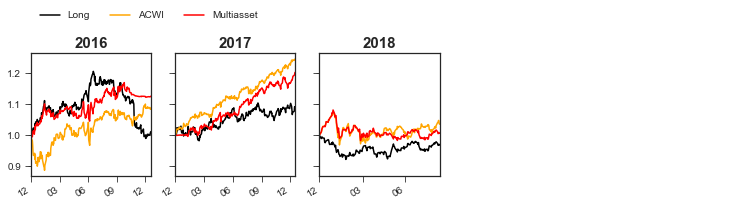

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [109]:
multiasset.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

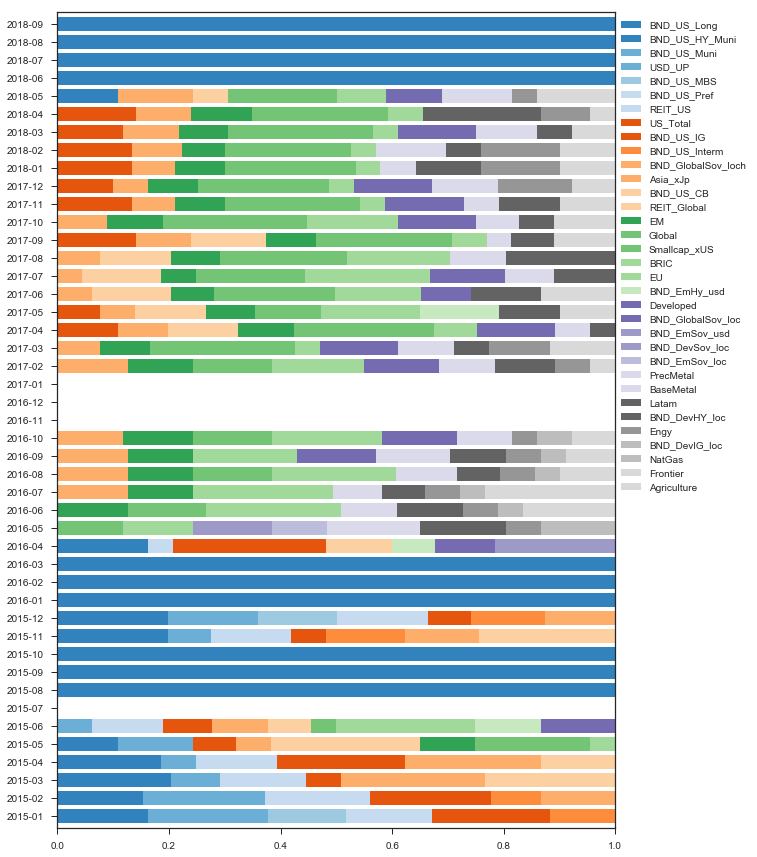

In [661]:
multiasset.plot_weight([2015, 2018])

# Global equity allocation model

In [254]:
geam = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    n_picks=5, 
    assets=setting.assets_global_eq, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=24, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Short', 
    start='2002-12-31', 
    losscut=0.05, 
)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

26.638986587524414


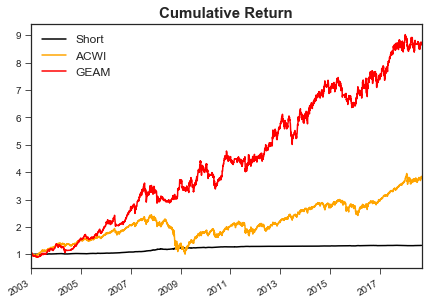

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [255]:
strats = ['BND_US_Short', 'ACWI', 'DualMomentum']
names = ['Short', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

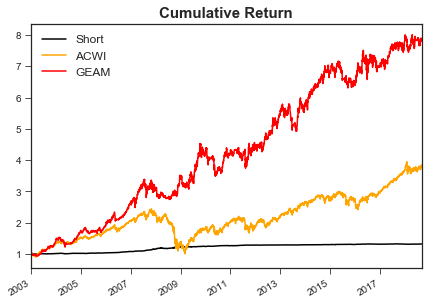

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [59]:
strats = ['BND_US_Short', 'ACWI', 'DualMomentum']
names = ['Short', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

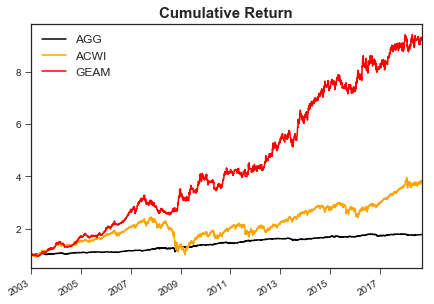

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [176]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

In [582]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Germany,4.27,3946,9.63,25.61,0.38,-63.09,15.63,20.69,0.78,1.22,28.92,58.29,1.09,18.80
Switzerland,4.12,3946,9.38,19.92,0.47,-51.62,13.52,15.97,0.82,0.88,26.35,62.57,0.99,74.16
Sweden,5.60,3946,11.53,29.78,0.39,-68.07,16.94,22.87,0.76,1.37,33.22,55.61,1.31,23.13
Russia,0.66,2858,-3.60,43.32,-0.08,-81.89,1.37,34.66,0.05,1.65,48.22,49.63,1.09,17.65
DualMomentum,9.93,3946,15.66,16.32,0.96,-22.79,15.02,15.36,1.02,0.24,9.76,60.43,1.47,92.78


In [133]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
France,3.09,3946,7.42,25.35,0.29,-61.41,13.64,19.95,0.73,1.22,33.38,57.75,1.05,-4.90
Switzerland,4.12,3946,9.38,19.92,0.47,-51.62,13.52,15.97,0.82,0.88,26.35,62.57,0.99,74.16
HongKong,5.06,3946,10.82,24.73,0.44,-63.58,15.66,18.73,0.91,1.02,20.48,63.64,0.94,74.13
Netherland,3.48,3946,8.22,24.30,0.34,-65.22,13.69,18.82,0.76,1.15,24.72,62.03,0.91,52.94
DualMomentum,5.33,3946,11.19,13.76,0.81,-19.44,10.59,13.13,0.78,0.18,14.69,59.89,1.30,85.27


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [482]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Italy,1.51,3946,2.66,28.21,0.09,-70.38,8.66,23.36,0.40,1.27,39.25,55.08,0.98,-113.57
Indonesia,8.79,3946,14.77,29.99,0.49,-72.14,17.52,28.43,0.68,0.67,28.00,61.50,1.05,37.32
BND_US_Long,2.42,3946,5.77,13.43,0.43,-26.58,6.25,12.66,0.53,-0.28,24.43,55.08,1.22,94.34
Turkey,2.76,3946,6.65,39.91,0.17,-76.62,9.22,33.78,0.28,1.35,41.41,56.68,1.01,-96.08
DualMomentum,9.93,3946,15.66,16.32,0.96,-22.79,15.02,15.36,1.02,0.24,9.76,60.43,1.47,92.78


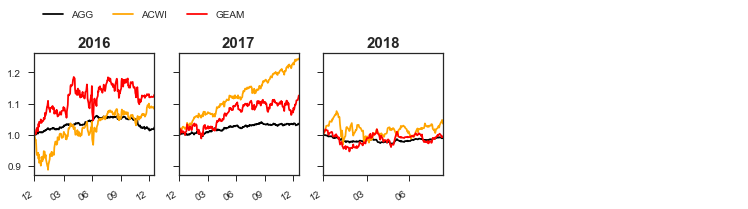

In [483]:
geam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

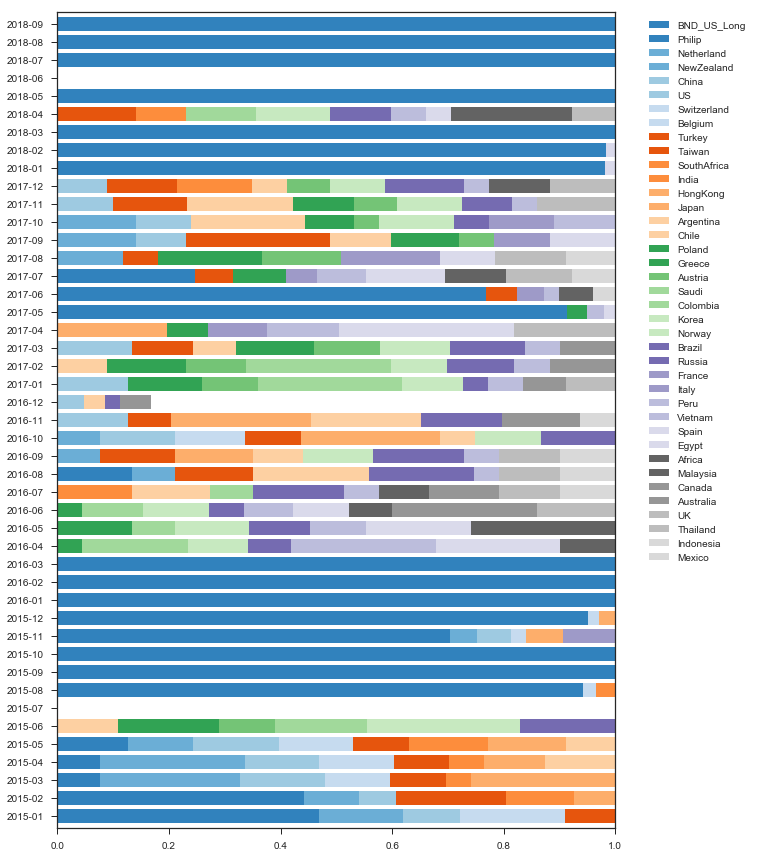

In [484]:
geam.plot_weight([2015, 2018])

# Global sector allocation model

In [258]:
gsam = q.Backtester(
    setting.base_params(db), 
    w_type='inv_ranky2', 
    n_picks=10, 
    assets=setting.assets_global_sector, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,0,0,0], 
    sig_w_dynamic=True, #False, 
    sig_dyn_fwd=21*np.array([1]), 
    #sig_dyn_m_backs=24, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(20,60), 
    strong_condition=True, 
    market='ACWI', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_AGG', 
    start='2002-12-31', 
    losscut=0.05,
)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

32.64534568786621


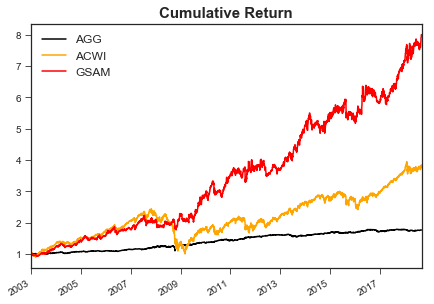

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [259]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GSAM']
color = ['k', 'orange', 'r']

gsam.plot_cum(strats, names=names, color=color, logy=False)

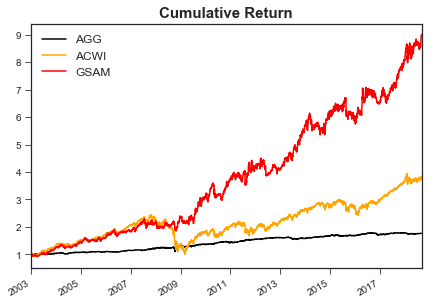

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [62]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GSAM']
color = ['k', 'orange', 'r']

gsam.plot_cum(strats, names=names, color=color, logy=False)

In [136]:
gsam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
NaturalGas,1.56,3946,2.85,35.68,0.08,-89.45,10.77,28.13,0.40,1.28,40.09,57.22,0.91,-159.93
FoodBeverage,2.69,3322,7.74,15.45,0.50,-39.15,9.39,13.45,0.69,0.60,21.38,59.87,1.11,83.26
Aerospace,4.69,3108,13.25,20.95,0.63,-59.72,15.87,15.95,0.95,0.87,15.56,67.12,0.95,76.73
Infra,4.33,3946,9.73,18.79,0.52,-58.33,12.79,12.88,0.93,0.89,22.26,65.78,0.90,40.18
DualMomentum,7.14,3946,13.26,14.11,0.94,-20.48,12.79,12.86,1.00,0.32,10.58,64.71,1.17,97.04


In [710]:
gsam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Semiconductor,6.23,3946,12.30,27.46,0.45,-66.85,13.75,23.50,0.56,1.07,32.49,57.75,1.15,56.09
NaturalResource,4.57,3946,10.10,21.96,0.46,-63.09,16.19,17.34,0.97,0.96,30.89,58.29,1.13,-3.77
Transportation,5.82,3946,11.81,22.99,0.51,-60.39,16.65,18.49,0.89,0.96,21.96,60.96,1.09,84.30
Media,2.36,3322,6.67,21.60,0.31,-69.13,9.91,16.62,0.68,0.91,31.08,57.96,1.03,43.09
DualMomentum,8.51,3946,14.54,15.80,0.92,-22.09,15.06,13.73,1.01,0.37,8.47,63.10,1.27,98.23


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


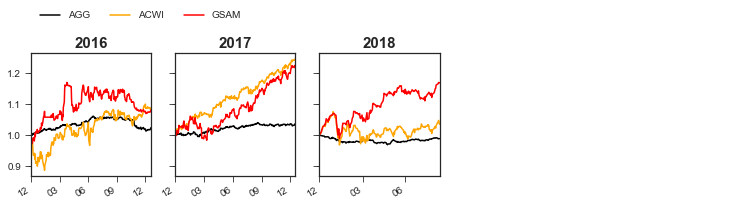

In [137]:
gsam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

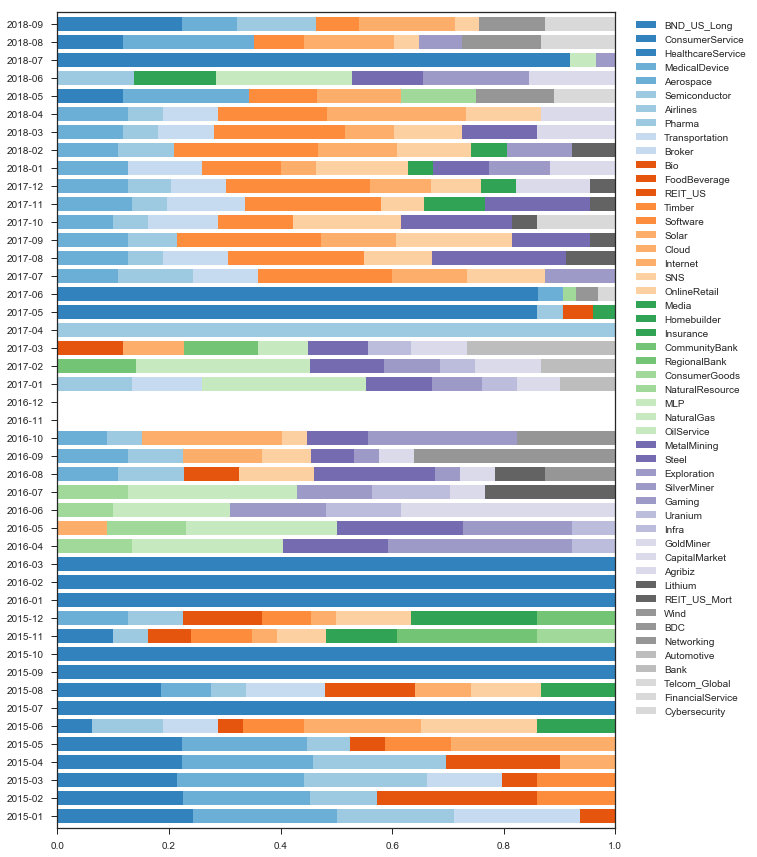

In [490]:
gsam.plot_weight([2015, 2018])

# Global fixed-income allocation model

In [274]:
gfam = q.Backtester(
    setting.base_params(db), 
    w_type='ranky2', 
    freq='1M', 
    n_picks=5, 
    assets=setting.assets_fi, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=False, 
    #sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=12, 
    follow_trend=(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='BND_US_AGG', #'BND_GlobalSov_loch', #'BND_US_AGG', 
    supporter='BND_US_Long', 
    cash_equiv='BND_US_Short', 
    start='2002-12-31', 
    losscut=0.05, 
)

HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


20.82631278038025


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


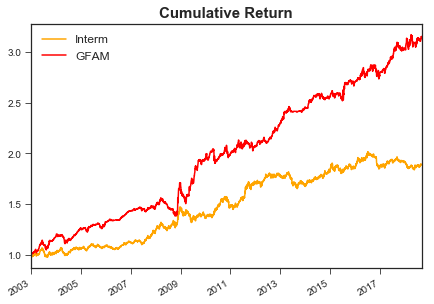

In [275]:
strats = ['BND_US_Interm', 'DualMomentum']
names = ['Interm', 'GFAM']
color = ['orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

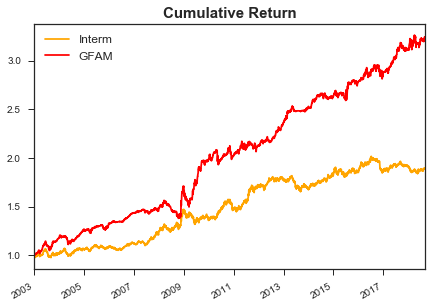

In [780]:
strats = ['BND_US_Interm', 'DualMomentum']
names = ['Interm', 'GFAM']
color = ['orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

In [217]:
gfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_EmSov_usd,3.19,3946,7.63,9.35,0.82,-34.70,8.23,6.69,1.41,0.14,17.72,68.98,0.90,87.03
BND_US_HY,2.69,3946,6.46,10.39,0.62,-34.25,6.67,6.39,1.29,0.34,16.12,70.05,0.81,90.13
BND_EmSov_loc,1.17,2688,1.50,11.01,0.14,-32.01,3.96,10.20,0.36,0.28,42.31,60.63,0.76,-0.79
BND_GlobalSov_loc,1.25,2754,2.02,8.74,0.23,-16.86,1.33,7.93,0.17,0.11,41.00,59.23,0.86,-10.83
DualMomentum,3.15,3946,7.55,6.16,1.23,-12.06,5.97,5.36,1.22,0.02,2.89,66.84,1.29,97.19


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [713]:
gfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_EmHy_usd,3.33,3946,7.92,7.03,1.13,-32.10,8.04,6.47,1.47,0.13,17.77,68.98,0.89,94.58
ACWI,3.80,3946,8.83,18.63,0.47,-58.79,13.42,12.52,1.09,1.00,22.32,63.10,0.98,65.88
BND_GlobalTip_loc,1.10,2634,0.89,9.99,0.09,-29.60,2.91,8.38,0.34,0.19,32.03,58.06,0.81,33.53
BND_US_HY,2.69,3946,6.46,10.39,0.62,-34.25,6.67,6.39,1.29,0.34,16.12,70.05,0.81,90.13
DualMomentum,2.89,3946,6.96,5.89,1.18,-10.99,5.40,4.99,1.17,0.03,4.54,66.31,1.24,95.91


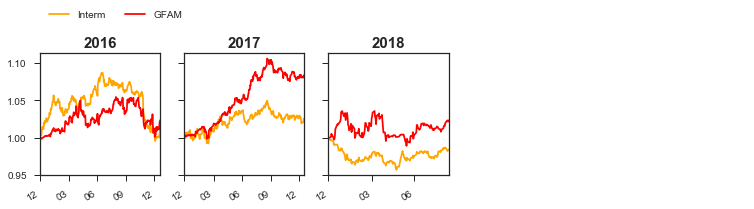

In [714]:
gfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2016))

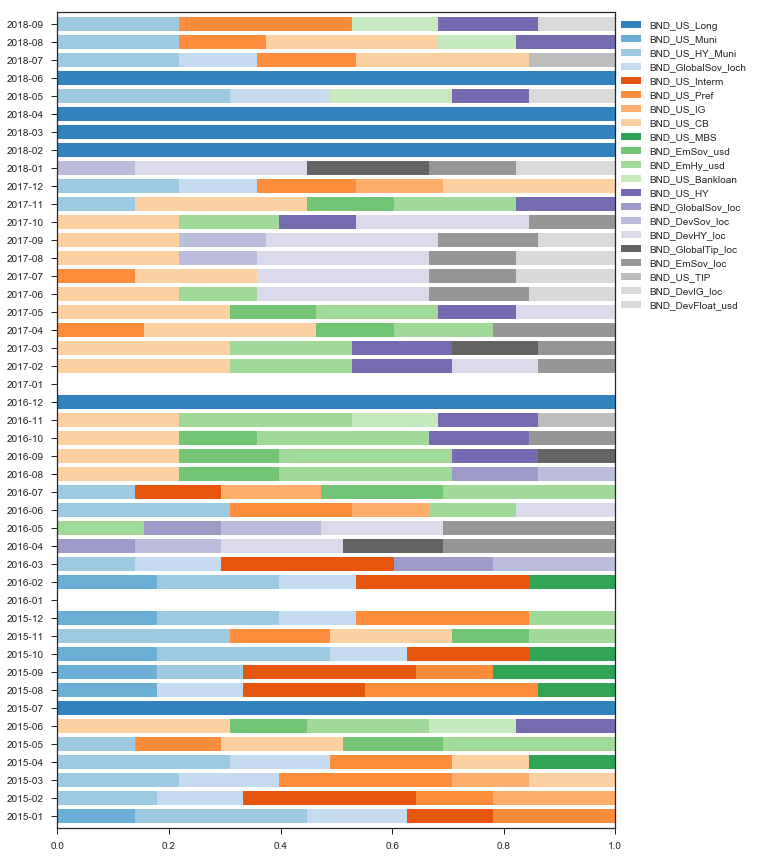

In [762]:
gfam.plot_weight([2015, 2018])

In [264]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Korea factor allocation model

In [281]:
kfam = q.Backtester(
    setting.base_params(db_kr), 
    w_type='inv_ranky2', # ranky2 가 더 잘나오긴 한다. ----
    freq='1M', 
    n_picks=5, 
    assets=setting.assets_kr_factor, #|setting.assets_us_factor2, 
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3], 
    sig_w_dynamic=True, 
    sig_dyn_fwd=21*np.array([1,2,3]), 
    #sig_dyn_m_backs=12, 
    follow_trend=None, #(20,60), 
    follow_trend_market=(20,60), 
    follow_trend_supporter=(60,250), 
    strong_condition=True, 
    market='K200', 
    supporter='KTB10YL', 
    cash_equiv= 'KTB10Y', 
    #trade_assets=[('K200', {'K200L':0.5})], 
    start='2002-12-31', 
    losscut=0.03, 
)

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


HBox(children=(IntProgress(value=0, max=189), HTML(value='')))

18.37584638595581


In [105]:
rt = kfam.cum.DualMomentum.resample('M').ffill().pct_change()
rt[rt<-0.05]

2003-10-31   -0.053422
2005-04-30   -0.052744
2006-05-31   -0.086460
2007-01-31   -0.066637
2007-11-30   -0.108383
2008-06-30   -0.064709
2009-01-31   -0.057171
2009-02-28   -0.113213
2011-02-28   -0.066878
2011-08-31   -0.094730
Name: DualMomentum, dtype: float64

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [117]:
rt = kfam.cum.DualMomentum.resample('M').ffill().pct_change()
rt[rt<-0.01]

2003-06-30   -0.010890
2004-01-31   -0.010082
2004-04-30   -0.010890
2005-01-31   -0.010134
2005-12-31   -0.010032
2006-03-31   -0.010890
2006-06-30   -0.010890
2006-10-31   -0.014693
2006-12-31   -0.011883
2007-01-31   -0.010890
2007-09-30   -0.010890
2007-11-30   -0.010890
2008-01-31   -0.010890
2008-02-29   -0.010890
2008-03-31   -0.010890
2008-06-30   -0.010876
2008-07-31   -0.010890
2009-06-30   -0.010029
2010-05-31   -0.010553
2011-05-31   -0.010890
2011-06-30   -0.010890
2011-08-31   -0.010890
2012-11-30   -0.010060
2013-06-30   -0.010308
2013-08-31   -0.010890
2013-11-30   -0.010890
2014-01-31   -0.013305
2014-12-31   -0.010890
2015-05-31   -0.010597
2015-06-30   -0.010890
2015-07-31   -0.010890
2016-08-31   -0.010890
2017-09-30   -0.010890
Name: DualMomentum, dtype: float64

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [37]:
p_max_ = kfam.p_close.iloc[-6].to_frame().T.append(kfam.p_close.tail(5)).cummax(); p_max_*0.95

,K200,MomentumGrowth_kr,DvdGrowth_kr,Value_kr,HighBeta_kr,KTB10Y,KTB10YL,HighDvd_kr,Quality_kr,LowVol_kr,Contrarian_kr,ESG_kr,ACWI,Growth_kr,K200L,Turnaround_kr,Momentum_kr
2018-08-24,28096.25,23018.5,14672.75,9661.50,12692.00,112898.00,118047.00,8706.75,9025.00,9523.75,24861.5,8768.50,69.8155,8497.75,12568.50,10996.25,11053.25
2018-08-27,28234.00,23465.0,14710.75,9680.50,12801.25,113140.25,118341.50,8706.75,9048.75,9566.50,25051.5,8768.50,70.4900,8559.50,12701.50,10996.25,11271.75
2018-08-28,28257.75,23465.0,14786.75,9775.50,12810.75,113244.75,118745.25,8706.75,9082.00,9642.50,25270.0,8801.75,70.5280,8588.00,12706.25,11115.00,11271.75
2018-08-29,28329.00,23465.0,14801.00,9837.25,12867.75,113263.75,118754.75,8706.75,9082.00,9642.50,25270.0,8811.25,70.9460,8626.00,12768.00,11295.50,11271.75
2018-08-30,28352.75,23465.0,14801.00,9837.25,12905.75,113263.75,118754.75,8706.75,9082.00,9642.50,25270.0,8811.25,70.9460,8626.00,12810.75,11295.50,11271.75
2018-08-31,28457.25,23465.0,14801.00,9837.25,12905.75,113520.25,119571.75,8706.75,9082.00,9642.50,25270.0,8811.25,70.9460,8626.00,12891.50,11295.50,11324.00


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [36]:
p_close_ = kfam.p_close.tail(6); p_close_

,K200,MomentumGrowth_kr,DvdGrowth_kr,Value_kr,HighBeta_kr,KTB10Y,KTB10YL,HighDvd_kr,Quality_kr,LowVol_kr,Contrarian_kr,ESG_kr,ACWI,Growth_kr,K200L,Turnaround_kr,Momentum_kr
2018-08-24,29575.0,24230.0,15445.0,10170.0,13360.0,118840.0,124260.0,9165.0,9500.0,10025.0,26170.0,9230.0,73.49,8945.0,13230.0,11575.0,11635.0
2018-08-27,29720.0,24700.0,15485.0,10190.0,13475.0,119095.0,124570.0,9150.0,9525.0,10070.0,26370.0,9225.0,74.20,9010.0,13370.0,11565.0,11865.0
2018-08-28,29745.0,24540.0,15565.0,10290.0,13485.0,119205.0,124995.0,9155.0,9560.0,10150.0,26600.0,9265.0,74.24,9040.0,13375.0,11700.0,11785.0
2018-08-29,29820.0,24645.0,15580.0,10355.0,13545.0,119225.0,125005.0,9165.0,9555.0,10140.0,26570.0,9275.0,74.68,9080.0,13440.0,11890.0,11775.0
2018-08-30,29845.0,24545.0,15420.0,10215.0,13585.0,119160.0,124795.0,9125.0,9455.0,10030.0,26410.0,9205.0,74.04,9010.0,13485.0,11795.0,11740.0
2018-08-31,29955.0,24650.0,15475.0,10250.0,13565.0,119495.0,125865.0,9155.0,9510.0,10105.0,26440.0,9255.0,73.81,9080.0,13570.0,11770.0,11920.0


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [48]:
p_max_*0.99 < p_close_

,K200,MomentumGrowth_kr,DvdGrowth_kr,Value_kr,HighBeta_kr,KTB10Y,KTB10YL,HighDvd_kr,Quality_kr,LowVol_kr,Contrarian_kr,ESG_kr,ACWI,Growth_kr,K200L,Turnaround_kr,Momentum_kr
2018-08-24,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-27,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-28,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-29,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-30,True,True,False,False,True,True,True,True,False,False,True,True,True,True,True,True,False
2018-08-31,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,False,True


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [49]:
(p_max_*0.99 < p_close_).cummin()

,K200,MomentumGrowth_kr,DvdGrowth_kr,Value_kr,HighBeta_kr,KTB10Y,KTB10YL,HighDvd_kr,Quality_kr,LowVol_kr,Contrarian_kr,ESG_kr,ACWI,Growth_kr,K200L,Turnaround_kr,Momentum_kr
2018-08-24,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-27,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-28,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-29,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2018-08-30,True,True,False,False,True,True,True,True,False,False,True,True,True,True,True,True,False
2018-08-31,True,True,False,False,True,True,True,True,False,False,True,True,False,True,True,False,False


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


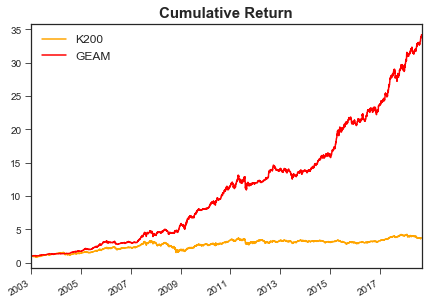

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [282]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

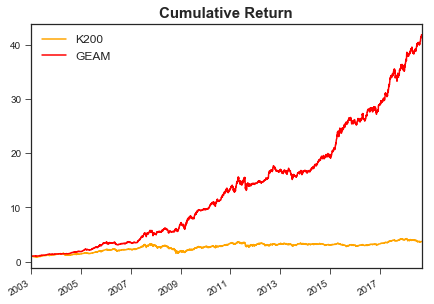

C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [74]:
strats = ['K200', 'DualMomentum']
names = ['K200', 'GEAM']
color = ['orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

In [71]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
LowVol_kr,7.60,4064,13.29,16.74,0.79,-43.38,11.72,14.36,0.85,0.25,20.21,58.29,1.41,62.21
DvdGrowth_kr,3.09,2378,12.60,14.11,0.89,-20.05,16.46,12.59,1.27,0.20,19.35,58.33,1.46,89.47
Momentum_kr,3.72,1728,20.95,19.19,1.09,-35.89,25.25,18.24,1.31,0.20,25.35,67.95,1.16,79.19
ACWI,3.80,4064,8.56,18.36,0.47,-58.79,13.00,12.35,1.09,1.00,21.91,63.10,0.98,65.92
DualMomentum,33.57,4064,24.13,13.07,1.85,-17.44,23.14,12.38,2.10,0.09,5.53,73.26,1.40,92.18


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [75]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
LowVol_kr,7.60,4064,13.29,16.74,0.79,-43.38,11.72,14.36,0.85,0.25,20.21,58.29,1.41,62.21
DvdGrowth_kr,3.09,2378,12.60,14.11,0.89,-20.05,16.46,12.59,1.27,0.20,19.35,58.33,1.46,89.47
Momentum_kr,3.72,1728,20.95,19.19,1.09,-35.89,25.25,18.24,1.31,0.20,25.35,67.95,1.16,79.19
ACWI,3.80,4064,8.56,18.36,0.47,-58.79,13.00,12.35,1.09,1.00,21.91,63.10,0.98,65.92
DualMomentum,41.89,4064,25.84,13.51,1.91,-17.37,24.38,12.57,2.22,0.09,5.09,73.26,1.49,92.48


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [85]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Growth_kr,8.54,4064,14.11,19.85,0.71,-57.34,11.43,17.39,0.69,0.32,23.72,60.43,1.26,51.40
K200L,1.54,2213,5.01,29.80,0.17,-53.96,-1.59,25.35,-0.06,0.48,52.44,57.43,0.98,-12.85
Turnaround_kr,1.61,1728,7.17,15.16,0.47,-26.82,8.19,13.45,0.62,0.26,17.17,56.41,1.12,78.71
Momentum_kr,3.72,1728,20.95,19.19,1.09,-35.89,25.25,18.24,1.31,0.20,25.35,67.95,1.16,79.19
DualMomentum,27.97,4064,22.75,9.84,2.31,-11.55,20.94,9.00,2.40,0.05,5.45,68.98,2.02,95.52


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [81]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Growth_kr,8.54,4064,14.11,19.85,0.71,-57.34,11.43,17.39,0.69,0.32,23.72,60.43,1.26,51.40
K200L,1.54,2213,5.01,29.80,0.17,-53.96,-1.59,25.35,-0.06,0.48,52.44,57.43,0.98,-12.85
Turnaround_kr,1.61,1728,7.17,15.16,0.47,-26.82,8.19,13.45,0.62,0.26,17.17,56.41,1.12,78.71
Momentum_kr,3.72,1728,20.95,19.19,1.09,-35.89,25.25,18.24,1.31,0.20,25.35,67.95,1.16,79.19
DualMomentum,36.18,4064,24.71,11.71,2.11,-16.37,23.88,10.68,2.27,0.06,5.66,70.05,1.76,95.11


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [26]:
kfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
ESG_kr,1.30,1512,4.40,10.82,0.41,-16.82,6.09,10.02,0.61,0.19,36.03,57.97,1.09,47.96
HighBeta_kr,5.07,4064,10.51,22.63,0.46,-61.10,11.26,18.50,0.53,0.35,30.54,59.89,1.08,57.07
LowVol_kr,7.60,4064,13.29,16.74,0.79,-43.38,11.72,14.36,0.85,0.25,20.21,58.29,1.41,62.21
Growth_kr,8.54,4064,14.11,19.85,0.71,-57.34,11.43,17.39,0.69,0.32,23.72,60.43,1.26,51.40
DualMomentum,38.60,4064,25.21,14.63,1.72,-21.14,23.71,13.58,2.08,0.10,7.18,72.19,1.39,91.54


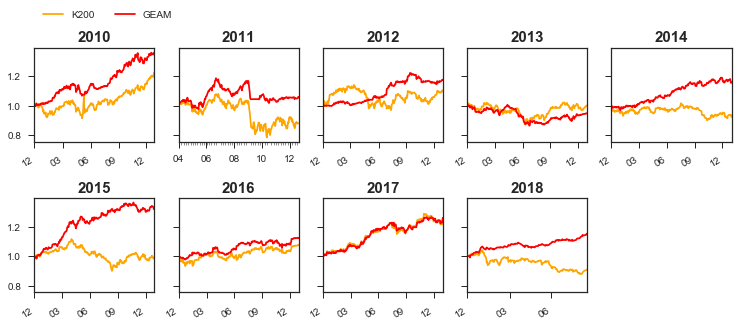

In [100]:
kfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2010))

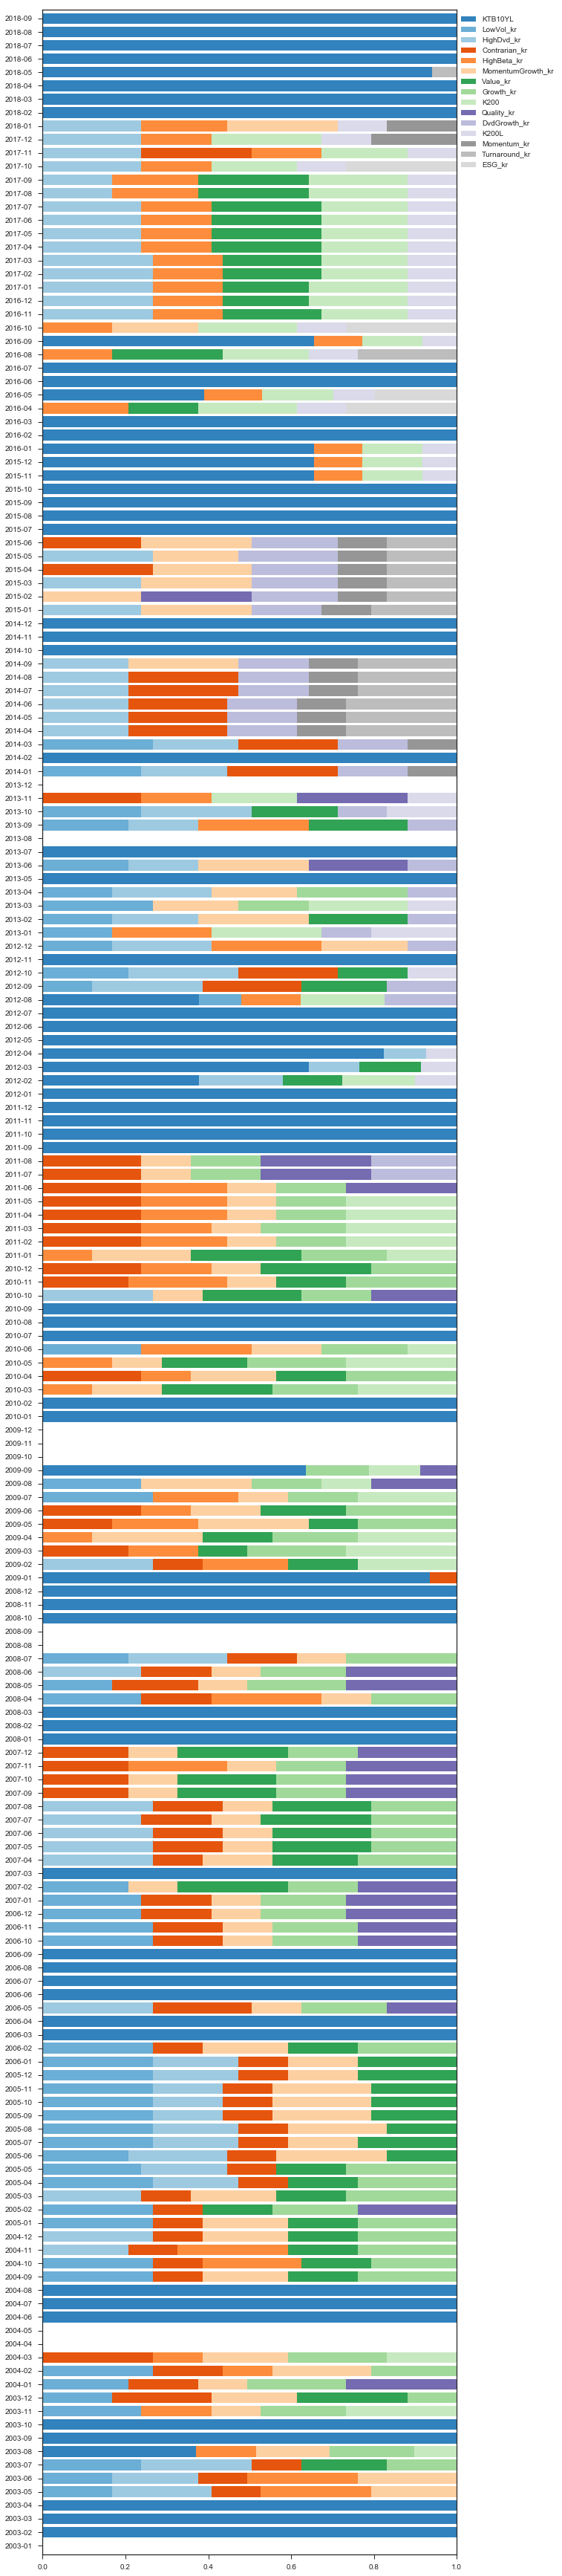

In [101]:
kfam.plot_weight([2003, 2018])

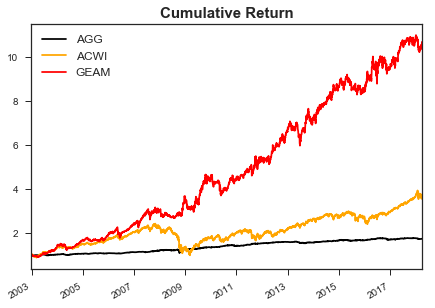

In [140]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

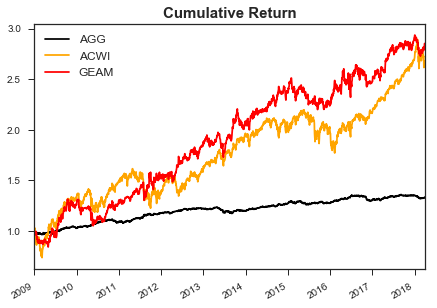

In [79]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

In [137]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
NewZealand,2.59,3839,6.39,12.28,0.52,-23.20,0.00,11.17,0.82,0.25,8.64,31.32,1.06,64.02
Russia,0.75,2751,-2.62,43.80,-0.06,-81.89,0.06,35.03,0.00,1.65,50.00,49.23,1.14,19.80
Chile,6.02,3839,12.40,23.04,0.54,-60.18,15.28,19.04,0.71,0.81,38.69,55.49,1.31,-45.83
Greece,0.70,1587,-5.37,43.46,-0.12,-77.39,10.20,40.40,0.25,1.65,43.57,51.35,1.04,28.94
DualMomentum,10.69,3839,16.69,15.32,1.09,-21.29,16.64,14.74,1.16,0.20,7.41,63.19,1.43,96.00


In [18]:
s1=pd.Series([1,2,3], index=['a','b','c'])
df=pd.DataFrame([[1,2,3],[4,5,6]], columns=['a','b','c']);df

,a,b,c
0,1,2,3
1,4,5,6


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [24]:
s1.to_frame().T.append(df)

,a,b,c
0,1,2,3
0,1,2,3
1,4,5,6


C:\Users\Sejin\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
